# 3. Рекомендательная система (20 баллов)

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

В этой практике мы попробуем построить очень простую рекомендательную систему, основанную на поиске кластера похожих пользователей.  
Похожие они в том плане, что смотрят одинаковые фильмы и оценивают их приблизительно одинаково.  
Мы будем строить очень простую модель, по сути которая даже не является именно системой рекомендации, но как минимум она может быть первым шагом к ее построению: мы найдем класет похожих пользователей, узнаем какие фильмы они смотрят и одинаково любят, какие жанры предпочитают.

Лабораторная будет больше похожа на манипулции с одним большим датафреймом. Если у вас появятся интересные идеи, то можете попробовать их тоже. 

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [1]:
import pandas as pd

In [2]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [3]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Classroom/data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('../../data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head(10)

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534


In [4]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Classroom/data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('../../data/anime/rating.csv.zip')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Обзор данных (1 балл)

Постройте графики для обзора признаков: anime.type, episodes, rating, members.

Посмотрите на info по таблицам, нам важно знать сколько оперативной памяти занимает каждая таблица, так как дальше у нас будет декартово произведение таблиц и размер может вылететь за 5 гигабайт.

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 32281 to 26081
Data columns (total 6 columns):
name        12017 non-null object
genre       12017 non-null object
type        12017 non-null object
episodes    12017 non-null object
rating      12017 non-null float64
members     12017 non-null int64
dtypes: float64(1), int64(1), object(4)
memory usage: 657.2+ KB


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
user_id     int64
anime_id    int64
rating      int64
dtypes: int64(3)
memory usage: 178.8 MB


In [8]:
anime.isnull().sum()

name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [9]:
ratings.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

#### anime.type

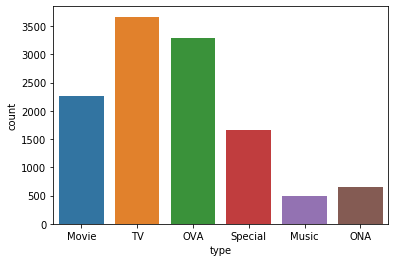

In [10]:
sns.countplot(anime.type);

#### anime.episodes

Для начала преобразуем в число и посмотрим на пропущенные значения

In [11]:
anime.episodes = pd.to_numeric(anime.episodes, errors='coerce')

In [12]:
anime.episodes.isnull().sum()

187

Посмотрим на пропущенные значения:

In [154]:
anime[anime.episodes.isna()]

,name,genre,type,episodes,rating,members
anime_id,,,,,,


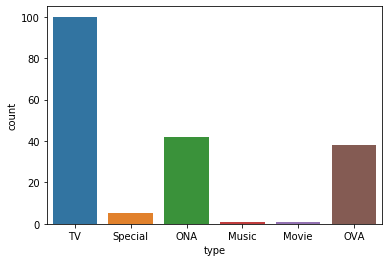

In [15]:
sns.countplot(anime[anime.episodes.isna()]['type']);

Вероятно фильмы еще не закончены и постоянно выпускаются новые эпизоды. Значений пропусков не много, да и суть задания не в этом, поэтому не стал париться, пропуски просто убрал, чтобы не мешались.

In [142]:
anime.dropna(axis=0,inplace=True)

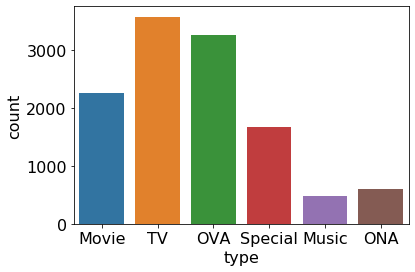

In [218]:
sns.countplot(anime['type']);

In [145]:
types = anime.type.unique()

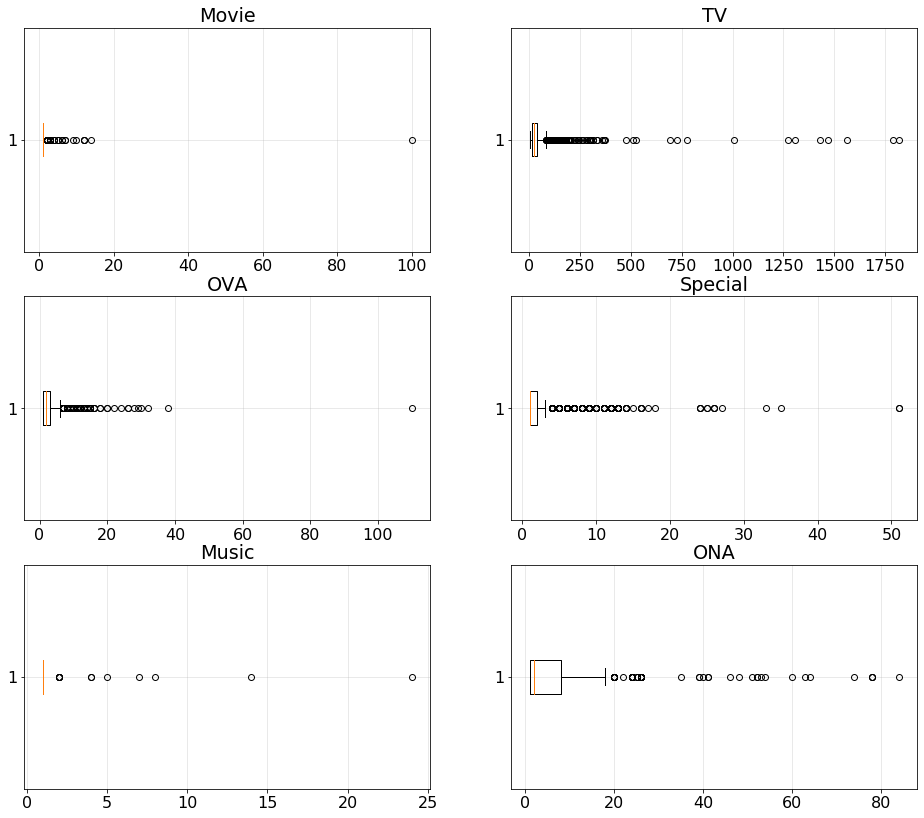

In [146]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 14))

i=0
for row, row_axes in enumerate(axes):
    for column, ax in enumerate(row_axes):
        ax.grid(alpha=0.35)
        x = anime[anime['type']==types[i]]['episodes']
        ax.boxplot(x,vert=False)
        ax.set_title(types[i])
        i+=1

#### anime.rating

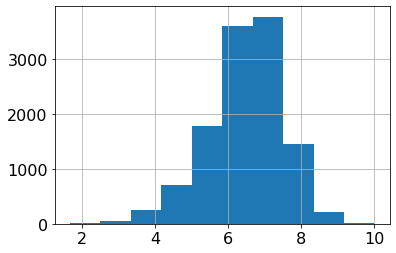

In [151]:
#Посмотрим н распределение рейтинга
anime.rating.hist();

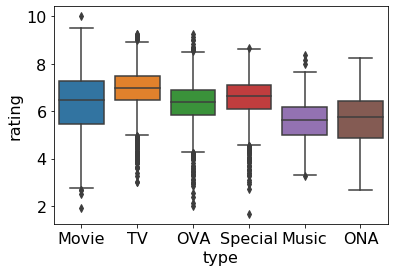

In [153]:
#Рейтинг в зависимости от категории фильма
sns.boxplot(data=anime,x='type',y='rating');

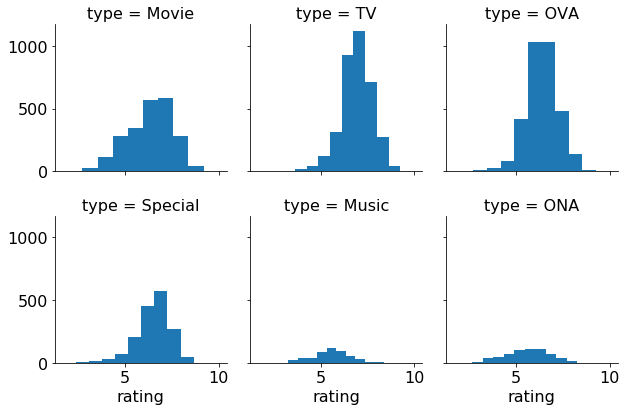

In [210]:
g = sns.FacetGrid(anime, col="type", col_wrap=3, height=3)
g.map(plt.hist, "rating");

In [157]:
anime.groupby('type')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
Movie,2258.0,6.334486,1.207021,1.92,5.45,6.49,7.260,10.00
Music,487.0,5.588665,0.959398,3.28,5.01,5.62,6.155,8.38
ONA,606.0,5.640479,1.125504,2.67,4.87,5.74,6.420,8.26
OVA,3246.0,6.371087,0.859524,2.00,5.85,6.37,6.910,9.25
Special,1665.0,6.525453,0.884138,1.67,6.09,6.63,7.110,8.66
TV,3568.0,6.929487,0.830774,3.00,6.47,6.96,7.470,9.26


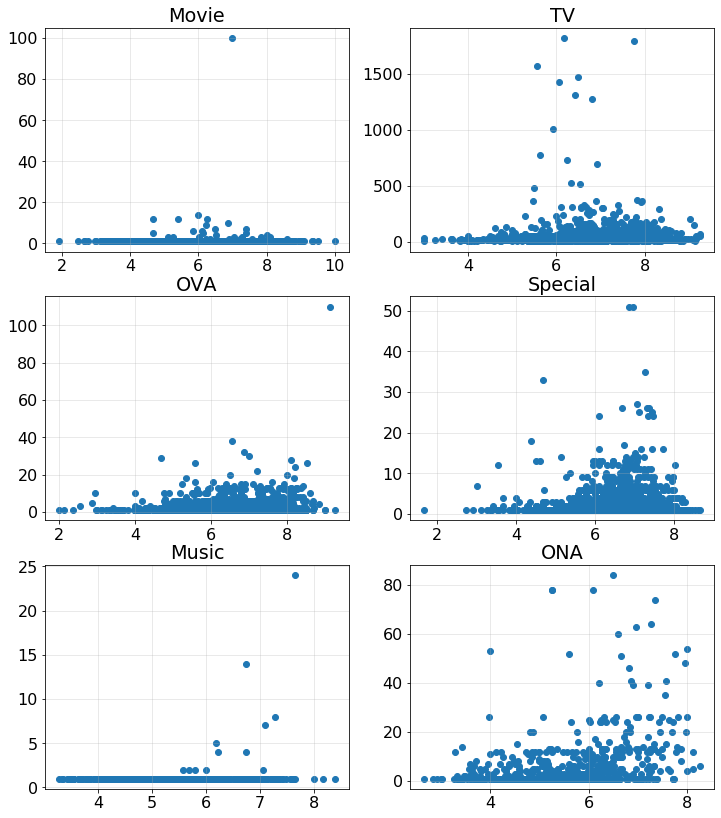

In [183]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

i=0
for row, row_axes in enumerate(axes):
    for column, ax in enumerate(row_axes):
        ax.grid(alpha=0.35)
        x = anime[anime['type']==types[i]]
        ax.scatter(data=x,x='rating',y='episodes')
        ax.set_title(types[i])
        i+=1

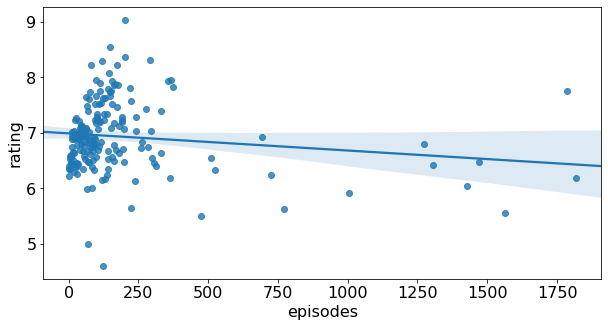

In [250]:
fsize = (10, 5)
fig, ax = plt.subplots(figsize=fsize)
sns.regplot(data=anime.groupby('episodes')['rating'].mean().reset_index(),x='episodes',y='rating')

#### anime.members

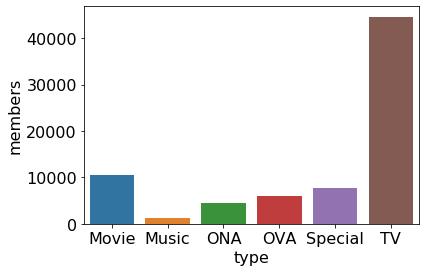

In [227]:
#Среднее количество подписчиков в зависимости от категории фаильма
sns.barplot(data=anime.groupby('type')['members'].mean().reset_index(),x='type',y='members');

Зависимости количества подписчиков от количества эпизодов не наблюдается:

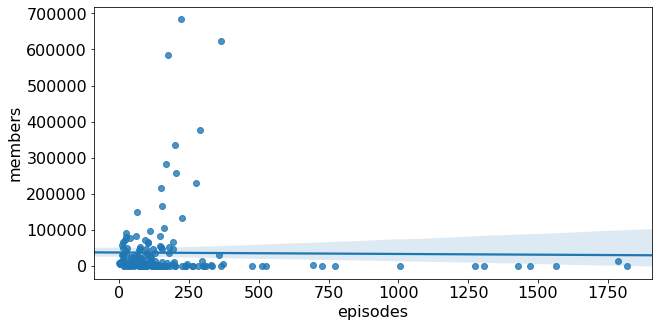

In [248]:
fsize = (10, 5)
fig, ax = plt.subplots(figsize=fsize)
sns.regplot(data=anime.groupby('episodes')['members'].mean().reset_index(),x='episodes',y='members')

## Жанры (4 балла)

Как в материалах к воркшопу постройте таблицу, в которой в строках будет названиефильма, а в столбцах жанр. В ячейках 1 - если в этого фильма есть такой жанр и 0 иначе.

Постройте countplot для визуализации количества фильмов каждого из жанров.

Постройте график, на котором будут изображениы распределения рейтингов по каждому из жанров. Должно получиться что-то подобное: ![Imgur](https://i.imgur.com/hyuA6ia.png)

Определим все множество жанров:

In [0]:
g_list = [g for g in anime['genre'].str.split(', ')]

In [0]:
from itertools import chain

In [0]:
g_set = set(chain.from_iterable(g_list))

In [0]:
genres = list(g_set) 

Сделаю новую таблицу заполненную нулями, дальше будем проставлять 1 в нужных столбцах:

In [0]:
anime_genre = pd.DataFrame(0,index=anime.index,columns=g_set)

In [20]:
anime_genre.head()

,Historical,Yaoi,Psychological,Comedy,Supernatural,Super Power,Magic,Space,Kids,Drama,Action,Sci-Fi,Sports,Shounen,Hentai,Martial Arts,Demons,Shoujo Ai,Romance,Cars,Dementia,Mystery,Ecchi,Game,Adventure,Slice of Life,Vampire,Horror,Music,Military,Yuri,School,Shoujo,Police,Fantasy,Thriller,Samurai,Mecha,Seinen,Josei,Shounen Ai,Parody,Harem
anime_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5114,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28977,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9253,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9969,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Проставляем еденицы в соответствующих жанрах всех аниме:

In [0]:
for i,r in anime.iterrows():
    for g in r['genre'].split(', '):
        if g is not None:
            anime_genre.loc[i][g] = 1

In [22]:
anime_genre.head()

,Historical,Yaoi,Psychological,Comedy,Supernatural,Super Power,Magic,Space,Kids,Drama,Action,Sci-Fi,Sports,Shounen,Hentai,Martial Arts,Demons,Shoujo Ai,Romance,Cars,Dementia,Mystery,Ecchi,Game,Adventure,Slice of Life,Vampire,Horror,Music,Military,Yuri,School,Shoujo,Police,Fantasy,Thriller,Samurai,Mecha,Seinen,Josei,Shounen Ai,Parody,Harem
anime_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5114,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
28977,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
9253,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9969,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [0]:
#? Какие плюсы/минусы у этой реализации? В врокшопе например использовались функции, более универсальное решение?

Посмотрим графически на количество жанров:

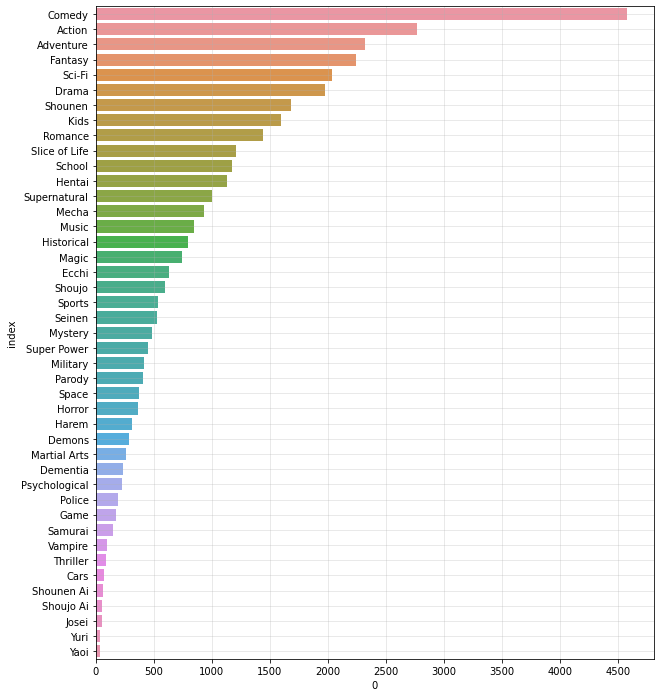

In [24]:
fsize = (10, 12)
fig, ax = plt.subplots(figsize=fsize)
sns.barplot(y='index',x=0, data=anime_genre.agg(sum).reset_index().sort_values(by=0,ascending=False))
plt.xticks(range(0, 5000, 500))
plt.grid(alpha=0.35)

Посмотрим на распределение рейтинга каждого из жанров:

In [145]:
anime.head()

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


In [0]:
#Объеденим оценки фильмов пользователями и жанры в новый датафрейм
df_m = ratings.join(anime_genre, on='anime_id').drop('anime_id', axis=1)

In [26]:
df_m.head()

,user_id,rating,Historical,Yaoi,Psychological,Comedy,Supernatural,Super Power,Magic,Space,Kids,Drama,Action,Sci-Fi,Sports,Shounen,Hentai,Martial Arts,Demons,Shoujo Ai,Romance,Cars,Dementia,Mystery,Ecchi,Game,Adventure,Slice of Life,Vampire,Horror,Music,Military,Yuri,School,Shoujo,Police,Fantasy,Thriller,Samurai,Mecha,Seinen,Josei,Shounen Ai,Parody,Harem
0,1,-1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,-1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,-1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,-1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,-1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
df_m[genres] = df_m[genres].multiply(df_m['rating'], axis='index')
df_m = df_m.drop(['rating'], axis=1).replace(0, np.NaN) # чтобы посчитать mean без учета непросмотренных фильмов
df_m.head()

,user_id,Historical,Yaoi,Psychological,Comedy,Supernatural,Super Power,Magic,Space,Kids,Drama,Action,Sci-Fi,Sports,Shounen,Hentai,Martial Arts,Demons,Shoujo Ai,Romance,Cars,Dementia,Mystery,Ecchi,Game,Adventure,Slice of Life,Vampire,Horror,Music,Military,Yuri,School,Shoujo,Police,Fantasy,Thriller,Samurai,Mecha,Seinen,Josei,Shounen Ai,Parody,Harem
0,1,NaN,NaN,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,NaN,NaN,-1.0,NaN,NaN,-1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0
3,1,NaN,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
4,1,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [0]:
#? Интересный кейс, выполнить определенные манипуляции с таблицами в условиях жестких ограничений памяти

In [0]:
#? Почему ставим именно -1? Чтобы зафильтровать на графике распределения?

Сгруппируем строки по пользователям (колонка `userId`).  
В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.

In [29]:
df = df_m.groupby('user_id').mean()
df.fillna(-1, inplace=True)
print(df.shape)
df.head()

(73515, 43)


,Historical,Yaoi,Psychological,Comedy,Supernatural,Super Power,Magic,Space,Kids,Drama,Action,Sci-Fi,Sports,Shounen,Hentai,Martial Arts,Demons,Shoujo Ai,Romance,Cars,Dementia,Mystery,Ecchi,Game,Adventure,Slice of Life,Vampire,Horror,Music,Military,Yuri,School,Shoujo,Police,Fantasy,Thriller,Samurai,Mecha,Seinen,Josei,Shounen Ai,Parody,Harem
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.0000,-1.0,-1.000000,-0.773196,-0.813559,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,-0.560000,-1.000000,-1.000,-1.000000,-1.0,-1.000000,0.571429,-1.0,-0.602410,-1.0,-1.0,-1.000000,-0.492308,0.833333,-0.266667,-1.000000,-1.00,0.571429,-1.000000,-1.00,-1.0,-0.694444,-1.0,-1.0,-0.760870,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.000000,-0.676471
2,-1.0000,-1.0,-1.000000,4.500000,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,10.000,10.000000,-1.0,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,-1.00,-1.0,4.500000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000
3,7.0000,-1.0,7.090909,7.435897,6.923077,6.900000,8.153846,-1.00,7.052632,7.451613,7.031250,6.300000,8.600,7.785714,-1.0,8.000000,6.500000,-1.0,7.555556,-1.0,-1.0,7.700000,7.800000,7.000000,7.354167,7.800000,6.00,6.500000,-1.000000,8.00,-1.0,8.500000,7.0,10.0,7.576923,8.000000,6.000000,7.0,6.200000,-1.0,-1.0,-1.000000,-1.000000
4,-1.0000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000,-1.000000,-1.0,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00,-1.000000,-1.000000,-1.00,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.000000
5,6.1875,-1.0,4.142857,4.076687,4.240000,4.047619,4.058824,7.25,5.555556,5.217949,4.592357,4.620253,5.825,4.652439,-1.0,4.115385,3.900000,1.0,2.942308,6.0,1.0,3.666667,2.510000,4.100000,5.053763,4.432432,3.75,4.166667,4.727273,4.75,-1.0,3.466216,3.0,2.5,4.354167,7.285714,7.166667,2.0,4.210526,7.0,-1.0,4.809524,2.217949


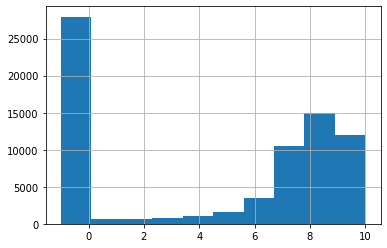

In [58]:
df['Historical'].hist()

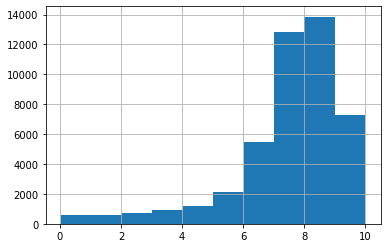

In [88]:
df[df['Historical']>0]['Historical'].hist()

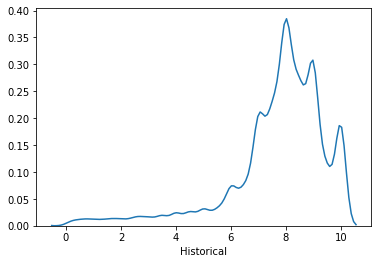

In [105]:
sns.distplot(df[df['Historical']>0]['Historical'],hist=False)

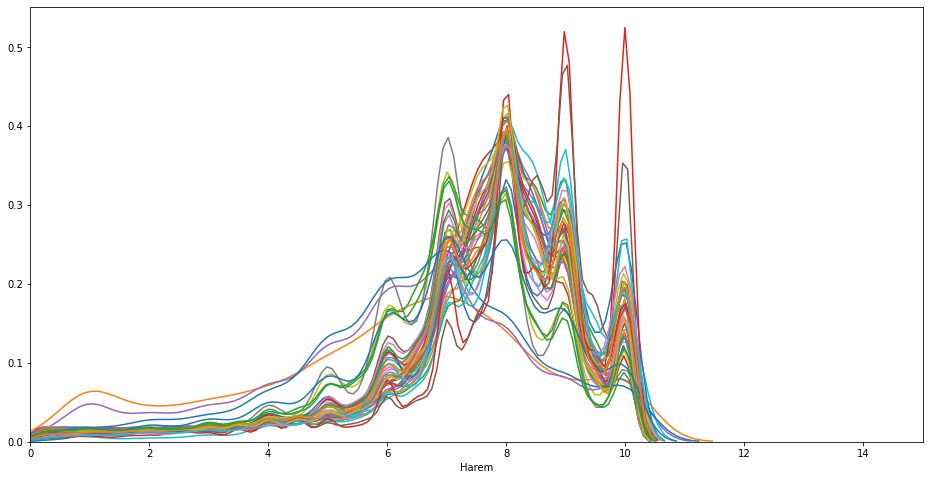

In [110]:
fsize = (16, 8)
fig, ax = plt.subplots(figsize=fsize)
ax.set_xlim(0,15);
for col in df.columns:
  sns.distplot(df[df[col]>0][col],hist=False)

In [0]:
sns.kdeplot

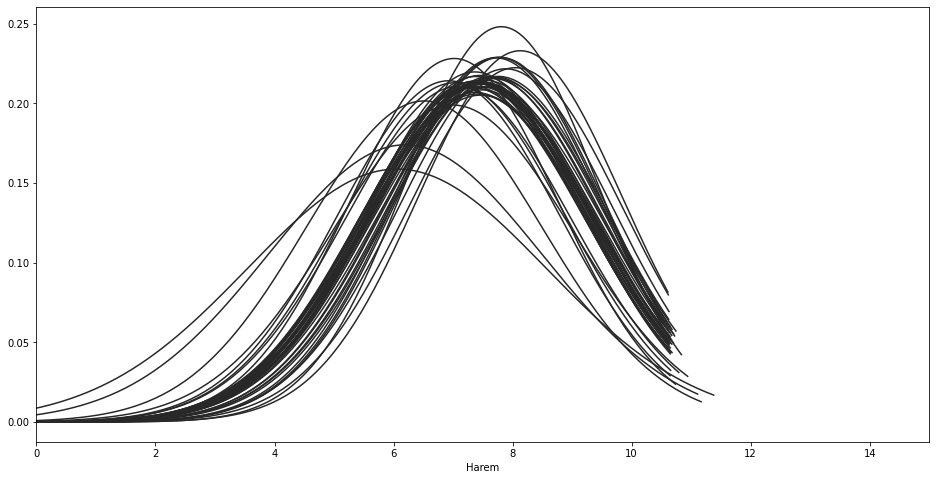

In [109]:
from scipy.stats import norm


fsize = (16, 8)
fig, ax = plt.subplots(figsize=fsize)
ax.set_xlim(0,15);
for col in df.columns:
  sns.distplot(df[df[col]>0][col],hist=False, fit=norm, kde=False)

## Рейтинг (1 балл)

Постройте график, показывающий сколько оценок каждого рейтинга поставили пользователи из таблицы `ratings`.

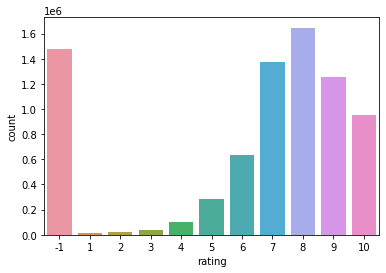

In [111]:
sns.countplot(ratings['rating']);

## Фильтрация данных (5 баллов)

Если мы сразу же построим кросстаб матрицу `anime` vs `user`, где в ячейках рейтинг, который поставил юзер этому фильму, то у нас это все займет около 6 гигабайт памяти. Можно значительно сократить размер матрицы, если выкинуть данные об аниме, которое почти никто не оценил и юзеров, которые почти ничего не оценивали.

Для этого постройте два новых датафрейма:

- anime_watches, где индексом является anime_name, а значением - количество его обзоров
- user_ratings, где индексом является user_id, а значением - количество вниме, которое он оценил.

Далее, соедините (join) 4 таблицы: ratings, anime, anime_watches, user_ratings и назовите новую таблицу anime_ratings.

Что означает `-1` в таблице рейтинга? Замените все -1 на средний рейтинг аниме.

Удалите из таблицы все те значения, у которых количество обзоров и рейтингов меньше медианного значения. То есть мы удалим половину аниме и половину юзеров.

In [146]:
anime.head()

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


In [147]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [153]:
ratings.groupby(['anime_id'])['rating'].count()

anime_id
1        15509
5         6927
6        11077
7         2629
8          413
         ...  
34367        5
34412        1
34475        4
34476        1
34519        1
Name: rating, Length: 11200, dtype: int64

In [138]:
df_countrate.head()

rating,-1,1,2,3,4,5,6,7,8,9,10
anime_id,,,,,,,,,,,
1,0.132826,0.000451,0.000451,0.000838,0.002063,0.007286,0.021729,0.078406,0.172545,0.250822,0.332581
5,0.164140,NaN,0.000289,0.000866,0.002887,0.008662,0.029739,0.112747,0.260286,0.257399,0.162985
6,0.152749,0.000271,0.000451,0.000993,0.002799,0.011555,0.032500,0.125214,0.247450,0.251061,0.174957
7,0.174971,0.001521,NaN,0.004184,0.014074,0.045264,0.088246,0.234690,0.248383,0.127425,0.061240
8,0.254237,NaN,NaN,0.007264,0.014528,0.062954,0.135593,0.210654,0.198547,0.065375,0.050847


In [143]:
df_countrate[df_countrate[-1]>0.8]

rating,-1,1,2,3,4,5,6,7,8,9,10
anime_id,,,,,,,,,,,
1396,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1863,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2075,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2635,0.875,NaN,NaN,NaN,NaN,0.125,NaN,NaN,NaN,NaN,NaN
2642,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
34173,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34358,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34412,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Матрица user-item (3 балла)

Превратите таблицу anime_ratings в матрицу, где в строках user_id, в стобцах anime_name, а в ячейках рейтинг. Посмотрите сколько занимет в памяти эта матрица.

In [0]:
#piwot table

#numpy sparse matrix

## Понижение размерности (1 балл)

kNN будет плохо работать на многомерных данных, поэтому надо понизить размерности матрицы с помощью алгоритма PCA. Количество размерностей установите от 4 до 10 - как вам покажется оптимальнее. (можете это исправить когда запустите kNN и получите результаты).

## Обучение kMeans (1 балл)

Обучим kMeans, чтобы он нашел нам центры кластеров нашей выборки.

Так как в строках у нас user_id, то центры класетров - это будут характеристики пользователей в терминах их оценок аниме. Используя эту информацию мы можем вычислить список характерных аниме для конкретного кластера.

- обучите kMeans
- создайте копию матрицы и добавьте новую колонку - кластер. Положите в нее результат предсказания кластера для каждого пользователя. (метод predict)
- нарисуйте cout plot количества юзеров в каждом кластере. Если получается сильно неравномерное распределение, то вам надо подобрать другое количество кластеров или изменить размерность в предыдущем шаге.

## Top 15 аниме (2 балла)

Найдем Top-15 аниме для каждого кластера. Для этого:

- найдите средний рейтинг аниме в каждом кластере. 
- для каждого кластера возьмите набор аниме с их средним рейтингом, отсортируйте этот набор по убыванию рейтинга. 
- возьмите первые 15 элементов из набора - это и будет топ15 аниме в кластере.
- согласны ли вы с содержимым кластера?

## Top 5 жанров (2 балла)

Если соеднить таблицу с аниме с таблицей жанров, то можно найти топ жанров для каждого кластера. Придумайте сами как это сделать, так как тут много способов:

- найти средний рейтинг для аниме каждого жанра
- посчитать сколько представителей каждого жанра есть среди top100 аниме кластера (кстати работает лучше)
- ???